In [110]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import  precision_score, recall_score, f1_score,balanced_accuracy_score
import seaborn as sns
from tqdm import tqdm
from utils.Preprocessing_utils import output_selection_prepro
from utils.heatmap_plots import plot_heat_map, plot_metrics
from predict_model import test_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.FeedForwardNet.model import Net as Net
from models.FeedForwardNet.model_3 import Net as Net3
from models.FeedForwardNet.model_2 import Net as Net2
from torchvision import models
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau
from utils.EarlyStopping import EarlyStopping
from imblearn.combine import SMOTEENN, SMOTETomek
import pytorch_warmup as warmup
import matplotlib.pyplot as plt
from IPython.display import Image
from pytorch_tabnet.tab_model import TabNetClassifier

In [111]:
df = pd.read_csv('data/raw/dukecathr.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [112]:

train_losses=[]
train_accu=[]
eval_losses=[]
eval_accu=[]
balance_accuracy_list = []
precision_list = []
recall_list = []

In [113]:
def train_epoch(model, dataloader, criterion, optimizer, lr_scheduler):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for data in tqdm(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        running_loss += loss.item()
    train_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    return train_loss, accu

In [114]:
def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted classes
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.detach().cpu().numpy())  # Detach the tensor before converting to numpy
    test_loss=running_loss/len(dataloader)
    test_accu=100.*correct/total
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    return test_loss, test_accu, balance_acc, precision, recall

In [115]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=25,target ='RCAST'):
    model_path=F'models/FeedForwardNet/saved_models/{target}/best_model.pth'
    model = model.to(device)
    all_learning_rates = []
    num_steps = len(train_dataloader) * num_epochs
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= 10, T_mult=2)
    #lr_scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau (optimizer,factor=0.3, patience=5)
    warmup_scheduler = warmup.RAdamWarmup(optimizer) #https://arxiv.org/pdf/1910.04209.pdf
    early_stopping = EarlyStopping(patience=30, verbose=True, model_path=model_path, delta=0.0001)

    for epoch in range(num_epochs):
        print(f'Epoch : {epoch+1}')
        train_loss, accu = train_epoch(model, train_dataloader, criterion, optimizer, lr_scheduler,warmup_scheduler)
        train_accu.append(accu)
        train_losses.append(train_loss)
        test_loss, test_accu, balance_acc, precision, recall = evaluate_epoch(model, test_dataloader, criterion)
        eval_losses.append(test_loss)
        eval_accu.append(test_accu)
        balance_accuracy_list.append(balance_acc)
        precision_list.append(precision)
        recall_list.append(recall)
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {accu:.3f} | Test Loss: {test_loss:.3f} | Test Accuracy: {test_accu:.3f} | Balance Accuracy: {balance_acc:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f}')
        all_learning_rates.append(optimizer.param_groups[0]["lr"])
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')
        #lr_scheduler.step()
   
            
         # Print the current learning rate
        # early_stopping(test_loss, model)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break
        # Save the model if the balanced accuracy is higher than the current best
        # if balance_acc > best_bal_acc:
        #     print(f'Balanced accuracy increased ({best_bal_acc:.6f} --> {balance_acc:.6f}).  Saving model ...')
        #     os.makedirs(os.path.dirname(model_path), exist_ok=True)
        #     torch.save(model.state_dict(), model_path)  # Save the model
        #     best_bal_acc = balance_acc  # Update the best balanced accuracy
    plt.plot(all_learning_rates)
    plt.show()
        

In [116]:
def evaluate_model(model, dataloader, criterion):
    model = model.to(device)  # Move the model to the GPU
    model.eval()  # Set model to evaluate mode
    running_loss=0
    correct=0
    total=0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data in tqdm(dataloader):
            images,labels=data[0].to(device),data[1].to(device)
            outputs=model(images)
            loss= criterion(outputs,labels)
            running_loss+=loss.item()
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round the output probabilities to get binary predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            # Store all labels and predictions for metric calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    test_loss=running_loss/len(dataloader)
    accu=100.*correct/total
    eval_losses.append(test_loss)
    eval_accu.append(accu)
    # Calculate metrics
    balance_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    # Append the metrics to the lists
    balance_accuracy_list.append(balance_acc)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f'Test Loss: {test_loss:.3f} | Accuracy: {accu:.3f}')

In [117]:
from pytorch_tabnet.tab_model import TabNetClassifier

def process_target(df, target):
    # Step 1: Preprocess the data
    X, y, num_cols, cat_cols = output_selection_prepro(df, target)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    # get how much 0 and 1 in y_train 
    unique, counts = np.unique(y_train, return_counts=True)
    print(dict(zip(unique, counts)))
    
    Scaler = StandardScaler()
    X_train = Scaler.fit_transform(X_train)
    X_test = Scaler.transform(X_test)
    
    input_dim = X_train.shape[1]
    # Define the model
    model = TabNetClassifier(
       
        input_dim=input_dim, output_dim=1,
    )
    
    # Train the model
    max_epochs = 150
    model.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_name=['train', 'valid'],
        eval_metric=['balanced_accuracy'],
        max_epochs=max_epochs,
        patience=30,
        batch_size=2048, virtual_batch_size=1024,
        num_workers=0,
        weights=1,
        drop_last=False
    )

    # Evaluate the model
    preds = model.predict(X_test)
    test_accu = (preds == y_test).mean()
    print(f'Test Accuracy: {test_accu:.3f}')


In [118]:
process_target(df, 'RCAST')

Loading data from data/processed/RCAST/imputed_data_RCAST.csv...


No missing values found.
Final X columns: ['RDAYSFROMINDEX', 'RSEQCATHNUM', 'RSUBJID', 'YRCATH_G', 'AGE_G', 'GENDER', 'RACE_G', 'DPCABG', 'DPMI', 'DPPCI', 'HXANGINA', 'HXCEREB', 'HXCHF', 'HXCOPD', 'HXDIAB', 'HXHTN', 'HXHYL', 'HXMI', 'HXSMOKE', 'NUMPRMI', 'DIASBP_R', 'PULSE_R', 'SYSBP_R', 'CBRUITS', 'HEIGHT_R', 'S3', 'WEIGHT_R', 'CREATININE_R', 'HDL_R', 'LDL_R', 'TOTCHOL_R', 'CATHAPPR', 'DIAGCATH', 'INTVCATH', 'CORDOM', 'GRAFTST', 'LVEF_R', 'DAYS2LKA', 'DSCABG', 'DSMI', 'DSPCI', 'DSSTROKE', 'FUPROTCL']
{0: 19109, 1: 31141}


c:\Users\charb\.conda\envs\mlenv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71983 | train_balanced_accuracy: 0.55869 | valid_balanced_accuracy: 0.55945 |  0:00:02s
epoch 1  | loss: 0.62706 | train_balanced_accuracy: 0.62339 | valid_balanced_accuracy: 0.62106 |  0:00:05s
epoch 2  | loss: 0.59855 | train_balanced_accuracy: 0.66363 | valid_balanced_accuracy: 0.65705 |  0:00:08s
epoch 3  | loss: 0.5786  | train_balanced_accuracy: 0.67589 | valid_balanced_accuracy: 0.66988 |  0:00:10s
epoch 4  | loss: 0.57039 | train_balanced_accuracy: 0.69017 | valid_balanced_accuracy: 0.68116 |  0:00:13s
epoch 5  | loss: 0.56148 | train_balanced_accuracy: 0.70142 | valid_balanced_accuracy: 0.69592 |  0:00:16s
epoch 6  | loss: 0.55216 | train_balanced_accuracy: 0.70374 | valid_balanced_accuracy: 0.69323 |  0:00:18s
epoch 7  | loss: 0.54934 | train_balanced_accuracy: 0.70926 | valid_balanced_accuracy: 0.69996 |  0:00:21s
epoch 8  | loss: 0.54323 | train_balanced_accuracy: 0.71042 | valid_balanced_accuracy: 0.70122 |  0:00:24s
epoch 9  | loss: 0.53736 | train_bala

c:\Users\charb\.conda\envs\mlenv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test Accuracy: 0.723


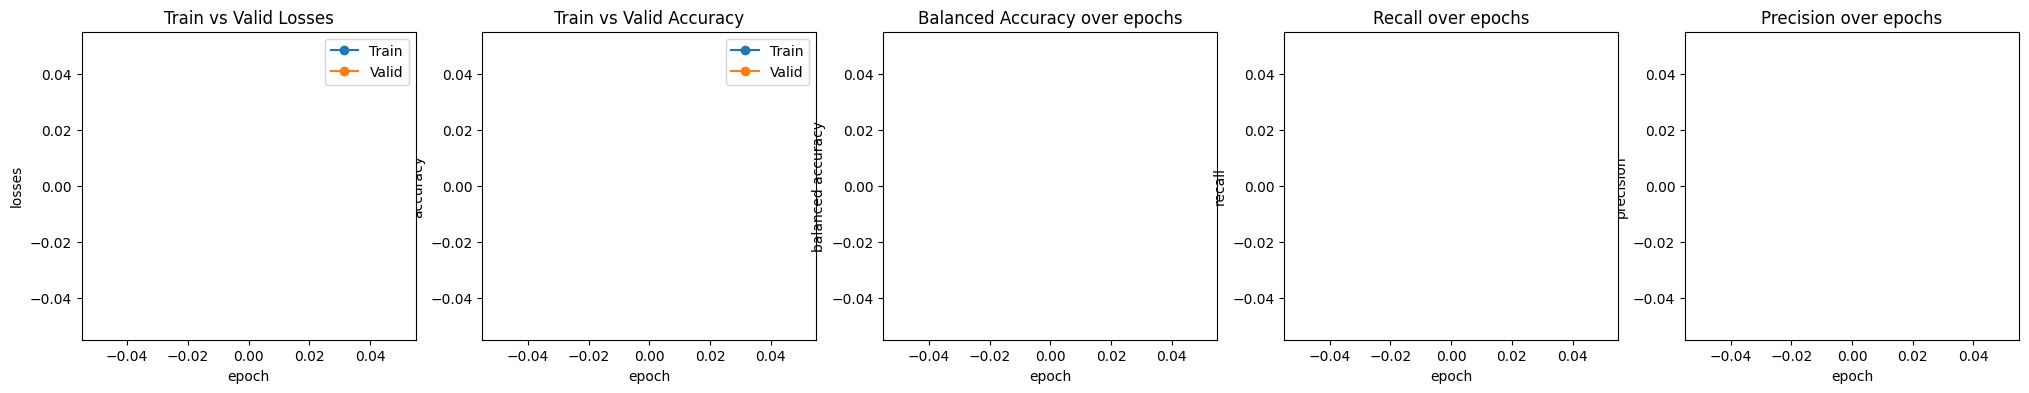

In [119]:
# plot the loss and accuracy and
metrics = {
    'train_losses': train_losses,
    'train_accu': train_accu,
    'eval_losses': eval_losses,
    'eval_accu': eval_accu,
    'balance_accuracy_list': balance_accuracy_list,
    'precision_list': precision_list,
    'recall_list': recall_list
}
plot_metrics(metrics, ['loss', 'accuracy', 'balance_accuracy', 'recall', 'precision'])

In [120]:
accuracy, precision, recall, balance_accuracy = test_model('models/FeedForwardNet/saved_model.pth', 'RCAST')

TypeError: test_model() takes 1 positional argument but 2 were given

In [ ]:
print(f'Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | Balance Accuracy: {balance_accuracy:.3f}')

Accuracy: 0.749 | Precision: 0.775 | Recall: 0.839 | Balance Accuracy: 0.720
